# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# ETL Pipeline Preparation


### 1. Import libraries and load datasets.

In [1]:
# import libraries
import datetime 
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [2]:
# load datasets
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 2.  Analysis and transformation of the source data.
Transformations involve cleaning the data, filtering out irrelevant information, aggregating data, splitting or merging fields, standardizing formats, and performing calculations.

#### 1) Let's examine the initial dataset called "portfolio".

In [3]:
portfolio.head(10)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


The 'portfolio' dataset consists of 10 entries and includes two categorical variables: 'channels' and 'offer_type'. It is worth noting that the 'channels' variable involves the value 'email' for all records, which makes it unimportant for future analyses.

In [4]:
# rename column
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)


In [5]:
# converting days into hours
portfolio['duration_hour'] = portfolio['duration']*24

# drop the old column
portfolio.drop(['duration'], axis=1, inplace=True )



In [6]:
# Work with categorical variables 'chanels'  
# For us, it is not essential 'email' as it is in all offers

# Creating a new column 'mobile' in the 'portfolio' dataset
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)

# Creating a new column 'web' in the 'portfolio' dataset
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

# Creating a new column 'social' in the 'portfolio' dataset
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

# drop the old column
#portfolio.drop(['channels'], axis=1, inplace=True )

In [7]:
# Work with categorical variables 'offer_type'
# Create OneHotEncoder object
encoder = OneHotEncoder()

# Perform one-hot encoding on the categorical variable
encoded_data = encoder.fit_transform(portfolio[['offer_type']])

# Convert sparse matrix to dense format and create a new DataFrame
onehot_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.categories_[0])

# Concatenate the original DataFrame and the new DataFrame with encoded features
portfolio = pd.concat([portfolio, onehot_df], axis=1)

# drop the old column
#portfolio.drop(['offer_type'], axis=1, inplace=True )


In [8]:
portfolio.head()

,reward,channels,difficulty,offer_type,offer_id,duration_hour,mobile,web,social,bogo,discount,informational
0,10,"[email, mobile, social]",10,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168,1,0,1,1.0,0.0,0.0
1,10,"[web, email, mobile, social]",10,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1,1,1,1.0,0.0,0.0
2,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,96,1,1,0,0.0,0.0,1.0
3,5,"[web, email, mobile]",5,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1,1,0,1.0,0.0,0.0
4,5,"[web, email]",20,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,0,1,0,0.0,1.0,0.0


In [9]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reward         10 non-null     int64  
 1   channels       10 non-null     object 
 2   difficulty     10 non-null     int64  
 3   offer_type     10 non-null     object 
 4   offer_id       10 non-null     object 
 5   duration_hour  10 non-null     int64  
 6   mobile         10 non-null     int64  
 7   web            10 non-null     int64  
 8   social         10 non-null     int64  
 9   bogo           10 non-null     float64
 10  discount       10 non-null     float64
 11  informational  10 non-null     float64
dtypes: float64(3), int64(6), object(3)
memory usage: 1.1+ KB


------------------------------------------------------------------------------------------

#### 2) Let's examine the initial dataset called "profile".

In [10]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [11]:
# rename column
profile.rename(columns={'id': 'user_id'}, inplace=True)


In [12]:
# converting int into date
date_member = pd.to_datetime(profile['became_member_on'], format="%Y%m%d").dt.strftime("%d.%m.%Y").tolist()
profile['date_member'] =date_member

profile['year'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d").dt.year

# drop the old column
profile.drop(['became_member_on'], axis=1, inplace=True )


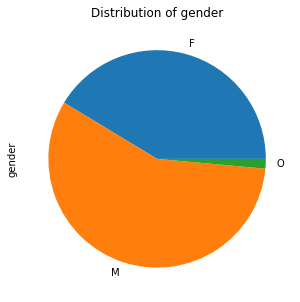

In [13]:
# Create a new figure with a specified size
plt.figure(figsize=(10,5))

# Group the 'profile' DataFrame by 'gender' and count the occurrences of each gender
gender_counts = profile.groupby('gender')['gender'].count()

# Create a pie chart using the gender counts
gender_counts.plot(kind='pie')

# Set the title of the plot
plt.title('Distribution of gender')

# Display the plot
plt.show()


In [14]:
# Fill None values in the income column with 0
profile['income'].fillna(0, inplace=True)

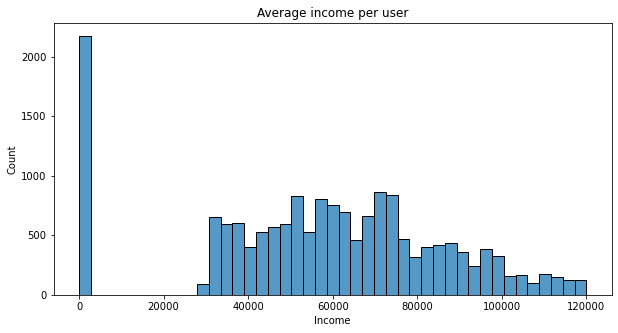

In [15]:
# Create a new figure with a specified size
plt.figure(figsize=(10,5))

# Create a histogram plot of the 'income' column in the 'profile' DataFrame using seaborn
sns.histplot(profile['income'])

# Set the title of the plot
plt.title('Average income per user')

# Set the x-axis label
plt.xlabel('Income')

# Set the y-axis label
plt.ylabel('Count')

# Display the plot
plt.show()


In [16]:
# Fill None values in the 'gender' column with 'O'
profile['gender'].fillna('O', inplace=True)

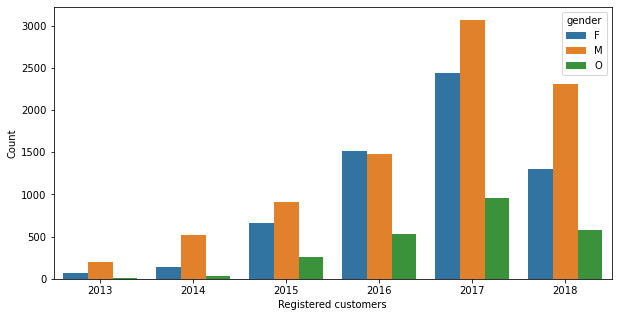

In [17]:
# Create a new figure with a specified size
plt.figure(figsize=(10,5))

# Grouping the DataFrame by 'year' and 'gender' and calculating the size/count
group_date_gender = profile.groupby(['year', 'gender']).size().reset_index()

# Renaming the columns of the DataFrame
group_date_gender.columns = ['year', 'gender', 'count']

# Creating a bar plot using seaborn
sns.barplot(x='year', y='count', hue='gender', data=group_date_gender)

# Setting the x-axis label
plt.xlabel('Registered customers')

# Setting the y-axis label
plt.ylabel('Count')

# Displaying the plot
plt.show()


In [18]:
# Work with categorical variables 'gender'
# Create OneHotEncoder object
encoder = OneHotEncoder()

# Perform one-hot encoding on the categorical variable
encoded_data = encoder.fit_transform(profile[['gender']])

# Convert sparse matrix to dense format and create a new DataFrame
onehot_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.categories_[0])

# Concatenate the original DataFrame and the new DataFrame with encoded features
profile = pd.concat([profile, onehot_df], axis=1)

# drop the old column
#profile.drop(['gender'], axis=1, inplace=True )

In [19]:
profile.head(100)

,gender,age,user_id,income,date_member,year,F,M,O
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,0.0,12.02.2017,2017,0.0,0.0,1.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,15.07.2017,2017,1.0,0.0,0.0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,0.0,12.07.2018,2018,0.0,0.0,1.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,09.05.2017,2017,1.0,0.0,0.0
4,O,118,a03223e636434f42ac4c3df47e8bac43,0.0,04.08.2017,2017,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
95,M,73,0ba6e2ad781c4429afd26cf0b35f2d11,51000.0,01.04.2018,2018,0.0,1.0,0.0
96,O,118,53bac762af27471eb294ff89ca1bae2c,0.0,06.08.2016,2016,0.0,0.0,1.0
97,F,50,b5abc1e85be84f43937b4fca0ad238cb,93000.0,06.05.2017,2017,1.0,0.0,0.0
98,F,90,1c587de019994f93a242c6864fd7bc55,98000.0,10.12.2015,2015,1.0,0.0,0.0


-----

#### 3) Let's examine the initial dataset called "transctiption".

In [20]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [21]:
# rename column
transcript.rename(columns={'person': 'user_id'}, inplace=True)


In [22]:
transcript.groupby('event').count()

,user_id,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


 During this period of time, we can observe individuals who received offers, those who read the offers, and individuals who spent money, made purchases, and completed the offers.

In [23]:
# Filtering 'transcript' dataset for 'transaction' events
df_transcript = transcript[transcript['event'] == 'transaction'].copy()

# Creating 'transaction_value' column
df_transcript['transaction_value'] = [float(val['amount']) for val in df_transcript['value']]

# Creating 'offer_id' and 'completed_value' columns
df_transcript['offer_id'] = [0]*len(df_transcript)
df_transcript['completed_value'] = [0]*len(df_transcript)

# Printing the shape and the first few rows of the 'df_transcript' DataFrame
print(df_transcript.shape)
df_transcript.head()



(138953, 7)


,user_id,event,value,time,transaction_value,offer_id,completed_value
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,0,0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,0,0


In [24]:
# Grouping 'df_transcript' DataFrame by 'user_id' and calculating the sum of 'transaction_value'
df_transcript[['user_id', 'transaction_value']].groupby('user_id').sum()


,transaction_value
user_id,
0009655768c64bdeb2e877511632db8f,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05
...,...
fff3ba4757bd42088c044ca26d73817a,580.98
fff7576017104bcc8677a8d63322b5e1,29.94
fff8957ea8b240a6b5e634b6ee8eafcf,12.15


Therefore, we can observe a total of 16 578 individuals who made purchases during this time frame.

---

The crucial aspect is to comprehend which individuals have utilized the offer.

In [25]:
# Filtering 'transcript' dataset for 'offer completed' events
df_completed = transcript[transcript['event'] == "offer completed"].copy()

# Creating 'transaction_value', 'offer_id', and 'completed_value' columns
df_completed['transaction_value'] = [0]*len(df_completed)
df_completed['offer_id'] = [val['offer_id'] for val in df_completed['value']]
df_completed['completed_value'] = [float(val['reward']) for val in df_completed['value']]

# Printing the shape and the first 100 rows of the 'df_completed' DataFrame
print(df_completed.shape)
df_completed.head(100)


(33579, 7)


,user_id,event,value,time,transaction_value,offer_id,completed_value
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,0,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,0,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
...,...,...,...,...,...,...,...
13948,a05d5de8d4314ec19162578f67af3fee,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,0,2906b810c7d4411798c6938adc9daaa5,2.0
13953,33834c812b4e47e4955093ad03f6117a,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
13965,c0231649f05d40889e3a6e1172303b37,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
13976,3b84fac9ca1148bb96b133ced98f565a,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0


In [26]:
df_completed[['user_id','completed_value']].groupby('user_id').sum()

,completed_value
user_id,
0009655768c64bdeb2e877511632db8f,9.0
0011e0d4e6b944f998e987f904e8c1e5,13.0
0020c2b971eb4e9188eac86d93036a77,14.0
0020ccbbb6d84e358d3414a3ff76cffd,13.0
003d66b6608740288d6cc97a6903f4f0,9.0
...,...
fff29fb549084123bd046dbc5ceb4faa,47.0
fff3ba4757bd42088c044ca26d73817a,9.0
fff7576017104bcc8677a8d63322b5e1,9.0


Therefore, we can observe 12 774 people who consciously or not have completed the offer.  Next step, we have to understand who from them received and saw the offer. 

In [27]:
# Filtering 'transcript' dataset for 'offer viewed' events
df_viewed = transcript[transcript['event'] == "offer viewed"].copy()

# Creating 'transaction_value', 'offer_id', and 'completed_value' columns
df_viewed['transaction_value'] = [0]*len(df_viewed)
df_viewed['offer_id'] = df_viewed['value'].apply(lambda val: str(val.get('offer id', '')))
df_viewed['completed_value'] = [0]*len(df_viewed)

# Printing the shape and the first 100 rows of the 'df_viewed' DataFrame
print(df_viewed.shape)
df_viewed.head(100)


(57725, 7)


,user_id,event,value,time,transaction_value,offer_id,completed_value
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,f19421c1d4aa40978ebb69ca19b0e20d,0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,5a8bc65990b245e5a138643cd4eb9837,0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,ae264e3637204a6fb9bb56bc8210ddfd,0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,5a8bc65990b245e5a138643cd4eb9837,0
...,...,...,...,...,...,...,...
12782,08e66f9936c545d4aedf21d35b96baf6,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,fafdcd668e3743c1bb461111dcafc2a4,0
12787,188540a144304408b5ce19148b295f31,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12788,250032cbd1b94b2b822f036f18fb407c,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12789,7e45faba0a8346379d0c296f1df8ae1d,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [28]:
# Check the values from df_comleted that are present in df_viewed

df_completed_tuples = df_completed[['user_id', 'offer_id']].apply(tuple, axis=1)

# Convert the 'user_id' and 'offer_id' columns of df_viewed to tuples
df_viewed_tuples = df_viewed[['user_id', 'offer_id']].apply(tuple, axis=1)

# Check if the tuples from df_comleted are present in df_viewed
is_present_mask = df_completed_tuples.isin(df_viewed_tuples)

# Filter df_comleted based on the is_present_mask
df_is = df_completed[is_present_mask]
df_not = df_completed[~is_present_mask]

print("Values present in df_viewed:")
print(f'Count = {len(df_is)}')
print("Values not present in df_viewed:")
print(f'Count = {len(df_not)}')


Values present in df_viewed:
Count = 28724
Values not present in df_viewed:
Count = 4855


We can observe a critical insight! Some people fulfilled the conditions of the promotion, but at the same time, they did not even know about it, did not receive or read information about the special offer.  A total of 28724 records show that people saw the information and took advantage of it, and 4855 records show that the conditions of the action were fulfilled unconsciously.

In [29]:
# Now we add the column indicating whether the offer has worked or not!
df_not.loc[:, 'offer_works'] = [0]*len(df_not)
df_is.loc[:,  'offer_works'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [30]:
df_is.head()

,user_id,event,value,time,transaction_value,offer_id,completed_value,offer_works
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,1
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,1
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,1


In [31]:
df_not.head()

,user_id,event,value,time,transaction_value,offer_id,completed_value,offer_works
12780,b860d355ef6e4c66b5d5a837c56ef32d,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0
12786,24115a61df25473e84a8a03f3c98de1a,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,0
12826,2481f1fcfbcb4b288e5a03af02d95373,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,0
12936,16dc4306258b4fef90ffe99f53ed7952,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0
12943,2c9a9137efff4820a47d56dbf0fa555f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0


In [32]:
# United in a single Dataset
df_completed_offer= pd.concat([df_is, df_not], ignore_index=True)
df_completed_offer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33579 entries, 0 to 33578
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            33579 non-null  object 
 1   event              33579 non-null  object 
 2   value              33579 non-null  object 
 3   time               33579 non-null  int64  
 4   transaction_value  33579 non-null  int64  
 5   offer_id           33579 non-null  object 
 6   completed_value    33579 non-null  float64
 7   offer_works        33579 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [33]:
print(f'The total  count unique people who have used the offer = {len(df_completed_offer["user_id"].unique())}')

The total  count unique people who have used the offer = 12774


-----

In [34]:
# Filtering the transcript dataframe to select rows where the event is "offer received"
df_received = transcript[transcript['event'] == "offer received"].copy()

# Initializing a new column named 'transaction_value' with all values set to 0
df_received['transaction_value'] = [0]*len(df_received)

# Extracting the 'offer id' from the 'value' column and storing it in a new column named 'offer_id'
df_received['offer_id'] = df_received['value'].apply(lambda val: str(val.get('offer id', '')))

# Initializing a new column named 'completed_value' with all values set to 0
df_received['completed_value'] = [0]*len(df_received)

# Printing the shape of the 'df_received' dataframe
print(df_received.shape)

# Displaying the first 100 rows of the 'df_received' dataframe
df_received.head(100)


(76277, 7)


,user_id,event,value,time,transaction_value,offer_id,completed_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
...,...,...,...,...,...,...,...
95,7c8479d8241344f6a0c306621e191c75,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,5a8bc65990b245e5a138643cd4eb9837,0
96,5404741ead9442bdbd4b9aa2273e85af,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0
97,81e9ad5fa55a4884b65e01a5db8f1b4e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,ae264e3637204a6fb9bb56bc8210ddfd,0
98,ed46fca6de7042478b411690878dc069,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,2906b810c7d4411798c6938adc9daaa5,0


#####  How many people who received the messages viewed them

In [35]:
# Convert the 'user_id' and 'offer_id' columns of df_viewed to tuples
df_viewed_tuples = df_viewed[['user_id', 'offer_id']].apply(tuple, axis=1)


# Convert the 'user_id' and 'offer_id' columns of df_received to tuples
df_received_tuples = df_received[['user_id', 'offer_id']].apply(tuple, axis=1)


# Check which values from df_received are present in  df_viewed_offer or not. 
is_present_mask = df_received_tuples.isin(df_viewed_tuples)

# Filter df_receved based on the is_present_mask
df_is = df_received[is_present_mask]
df_not = df_received[~is_present_mask]

print("Values present in df_received and df_viewed:")
print(f'Count = {len(df_is)}')
print("Values present in df_received but not in df_viewed:")
print(f'Count = {len(df_not)}')


Values present in df_received and df_viewed:
Count = 60285
Values present in df_received but not in df_viewed:
Count = 15992


According to the analysis results, it is clear that more than 1/4 of the received offers for various people have not been viewed. That is, people did not know about the proposals. 

---


#### Let's prepare a single dataset

In the future, we will use only those data for analysis the show that people knew that a marketing campaign was going on. 

In [36]:
df = pd.merge(df_completed_offer, portfolio, on='offer_id')
df = pd.merge(df, profile, on='user_id')
df.drop(['value'], axis=1, inplace=True )
df.drop(['event'], axis=1, inplace=True )

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            33579 non-null  object 
 1   time               33579 non-null  int64  
 2   transaction_value  33579 non-null  int64  
 3   offer_id           33579 non-null  object 
 4   completed_value    33579 non-null  float64
 5   offer_works        33579 non-null  int64  
 6   reward             33579 non-null  int64  
 7   channels           33579 non-null  object 
 8   difficulty         33579 non-null  int64  
 9   offer_type         33579 non-null  object 
 10  duration_hour      33579 non-null  int64  
 11  mobile             33579 non-null  int64  
 12  web                33579 non-null  int64  
 13  social             33579 non-null  int64  
 14  bogo               33579 non-null  float64
 15  discount           33579 non-null  float64
 16  informational      335

In [37]:
df.head(100)


,user_id,time,transaction_value,offer_id,completed_value,offer_works,reward,channels,difficulty,offer_type,...,discount,informational,gender,age,income,date_member,year,F,M,O
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"[web, email, mobile]",10,discount,...,1.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,540,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,1,10,"[web, email, mobile, social]",10,bogo,...,0.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,354,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,3,"[web, email, mobile, social]",7,discount,...,1.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,474,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1,5,"[web, email]",20,discount,...,1.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
4,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"[web, email, mobile]",10,discount,...,1.0,0.0,F,67,67000.0,29.09.2015,2015,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4a679284ed0241fdad87541ec0321066,696,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,3,"[web, email, mobile, social]",7,discount,...,1.0,0.0,F,78,72000.0,24.05.2014,2014,1.0,0.0,0.0
96,b1cf5025a03743708da33566672625c7,6,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"[web, email, mobile]",10,discount,...,1.0,0.0,F,61,115000.0,24.03.2016,2016,1.0,0.0,0.0
97,b1cf5025a03743708da33566672625c7,378,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"[web, email, mobile]",10,discount,...,1.0,0.0,F,61,115000.0,24.03.2016,2016,1.0,0.0,0.0
98,b1cf5025a03743708da33566672625c7,600,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,5,"[web, email, mobile, social]",5,bogo,...,0.0,0.0,F,61,115000.0,24.03.2016,2016,1.0,0.0,0.0


##### Let's make the data frame 'df_not_saw' for testing the model in the future. Users in this data frame didn't view the offer.    

In [38]:
df_not.loc[:, 'offer_works'] = [0]*len(df_not)
df_not_viewed = pd.merge(df_not, portfolio, on='offer_id')
df_not_viewed = pd.merge(df_not_viewed, profile, on='user_id')
df_not_viewed.drop(['value'], axis=1, inplace=True )
df_not_viewed.drop(['event'], axis=1, inplace=True )

df_not_viewed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15992 entries, 0 to 15991
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            15992 non-null  object 
 1   time               15992 non-null  int64  
 2   transaction_value  15992 non-null  int64  
 3   offer_id           15992 non-null  object 
 4   completed_value    15992 non-null  int64  
 5   offer_works        15992 non-null  int64  
 6   reward             15992 non-null  int64  
 7   channels           15992 non-null  object 
 8   difficulty         15992 non-null  int64  
 9   offer_type         15992 non-null  object 
 10  duration_hour      15992 non-null  int64  
 11  mobile             15992 non-null  int64  
 12  web                15992 non-null  int64  
 13  social             15992 non-null  int64  
 14  bogo               15992 non-null  float64
 15  discount           15992 non-null  float64
 16  informational      159

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


---

### 3. Save the clean DataFrame to a file!

In [39]:
# Assuming you want to save the DataFrame to a file named 'df_main.csv'
file_path = 'data//df_main.csv'

# Saving the DataFrame to a CSV file
df.to_csv(file_path, index=False)

print("DataFrame saved to CSV successfully!")


DataFrame saved to CSV successfully!


---


# Exploration Analysis and Visualization

In [40]:
# load the main dataset
df = pd.read_csv('data//df_main.csv')
df.head(100)

,user_id,time,transaction_value,offer_id,completed_value,offer_works,reward,channels,difficulty,offer_type,...,discount,informational,gender,age,income,date_member,year,F,M,O
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"['web', 'email', 'mobile']",10,discount,...,1.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,540,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,1,10,"['web', 'email', 'mobile', 'social']",10,bogo,...,0.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,354,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,3,"['web', 'email', 'mobile', 'social']",7,discount,...,1.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,474,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1,5,"['web', 'email']",20,discount,...,1.0,0.0,M,42,96000.0,17.01.2016,2016,0.0,1.0,0.0
4,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"['web', 'email', 'mobile']",10,discount,...,1.0,0.0,F,67,67000.0,29.09.2015,2015,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4a679284ed0241fdad87541ec0321066,696,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,3,"['web', 'email', 'mobile', 'social']",7,discount,...,1.0,0.0,F,78,72000.0,24.05.2014,2014,1.0,0.0,0.0
96,b1cf5025a03743708da33566672625c7,6,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"['web', 'email', 'mobile']",10,discount,...,1.0,0.0,F,61,115000.0,24.03.2016,2016,1.0,0.0,0.0
97,b1cf5025a03743708da33566672625c7,378,0,2906b810c7d4411798c6938adc9daaa5,2.0,1,2,"['web', 'email', 'mobile']",10,discount,...,1.0,0.0,F,61,115000.0,24.03.2016,2016,1.0,0.0,0.0
98,b1cf5025a03743708da33566672625c7,600,0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,5,"['web', 'email', 'mobile', 'social']",5,bogo,...,0.0,0.0,F,61,115000.0,24.03.2016,2016,1.0,0.0,0.0


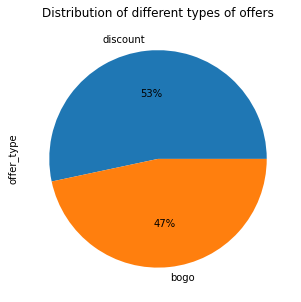

In [41]:
#Perform a thorough exploration of the distribution of offers

# Create a new figure with a specified size
plt.figure(figsize=(10,5))
df['offer_type'].value_counts().plot.pie(title='Distribution of different types of offers',autopct='%1.f%%');

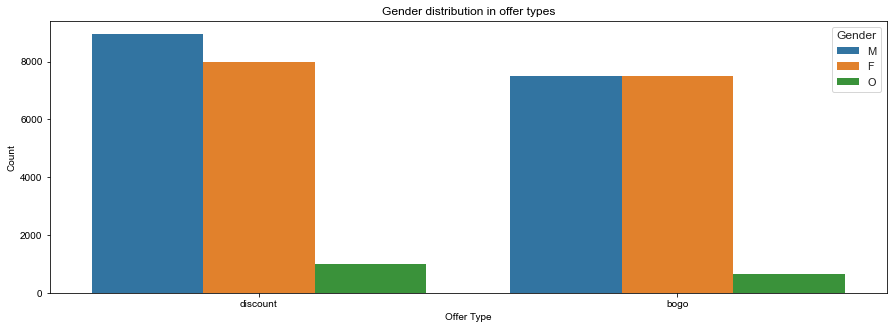

In [42]:
#Perform a thorough exploration of the distribution of gender distribution in diffrent offer types 
plt.figure(figsize=(15,5))
sns.countplot(x='offer_type',hue='gender',data=df)
sns.set(style='whitegrid')
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

We can see only two types offer for this data

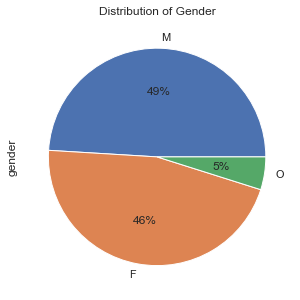

In [43]:
# Perform a thorough exploration of the distribution of gender
# Create a new figure with a specified size
plt.figure(figsize=(10,5))
df['gender'].value_counts().plot.pie(title='Distribution of Gender',autopct='%1.f%%');

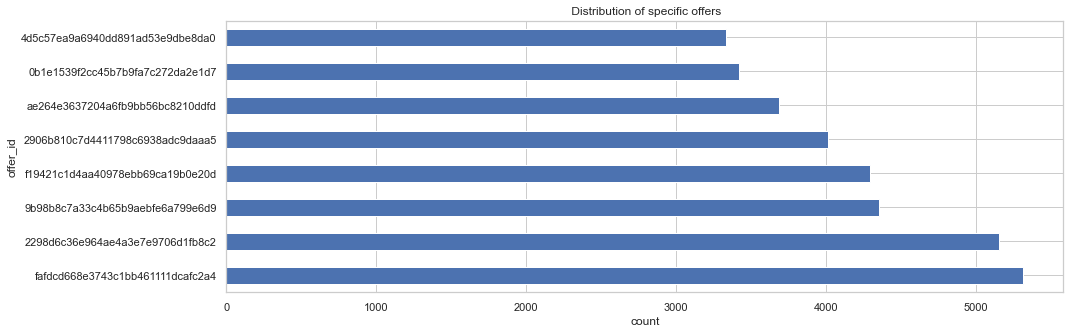

In [44]:
#Perform a thorough exploration of the specific offer distribution 
plt.figure(figsize=(15,5))
df['offer_id'].value_counts().plot(kind='barh', title=' Distribution of specific offers');
plt.xlabel('count')
plt.ylabel('offer_id')
plt.show()

In [45]:
# Add the new column different age categories
tmp_condition = [
    (df['age']<=18),
    (df['age']>18) &(df['age']<=35),
    (df['age']>35)&(df['age']<=65),
    (df['age']>65)
]
categories = ['<18', '18-35', '35-65', '>65']
df['age_cat']=np.select(tmp_condition,categories)


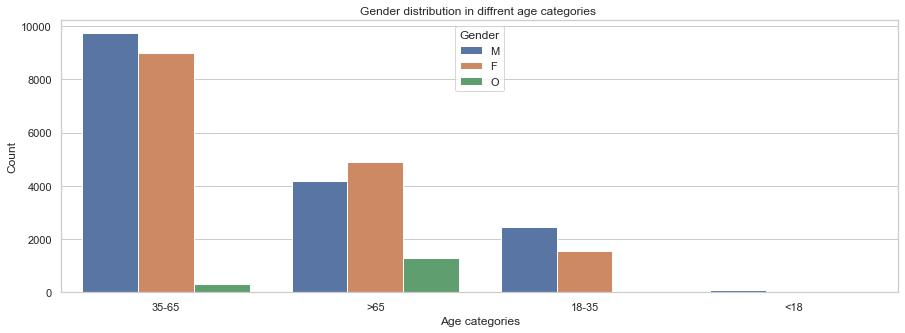

In [46]:
#Perform a thorough exploration of the distribution of gender distribution in diffrent age categories  
plt.figure(figsize=(15,5))
sns.countplot(x='age_cat',hue='gender',data=df)
plt.title('Gender distribution in diffrent age categories ')
plt.ylabel('Count')
plt.xlabel('Age categories')
plt.legend(title='Gender');

#### Result 
We performed an exploratory analysis and visualization of a dataset using Python and various libraries such as pandas, matplotlib, and seaborn. Here's a breakdown of the code:

1. Loading the dataset: The code loads a dataset from a CSV file named 'df_main.csv' using the pandas library and assigns it to the variable 'df.' It then displays the first 100 rows of the dataset using the 'head()' function.

2. Distribution of different types of offers: The code creates a pie chart using matplotlib to visualize the distribution of different types of offers in the dataset. The 'value_counts()' function is used to count the occurrences of each offer type, and the 'plot.pie()' function generates the pie chart.

3. Distribution of gender in different offer types: The code uses seaborn and matplotlib to create a countplot that shows the distribution of gender across different offer types. The 'countplot()' function is used, and the 'hue' parameter is set to 'gender' to differentiate the bars by gender.

4. Distribution of gender: The code creates a pie chart to visualize the distribution of gender in the dataset. Similar to the previous pie chart, it uses the 'value_counts()' function to count the occurrences of each gender and the 'plot.pie()'  function to generate the chart.

5. Distribution of specific offers: The code creates a horizontal bar chart using matplotlib to visualize the distribution of particular offers. The 'value_counts()' function counts the occurrences of each offer ID, and the 'plot()' function with 'kind='barh'' generates the chart.

6. Categorizing age: The code adds a new column to the dataframe named 'age_cat' that categorizes the age into different age categories (<18, 18-35, 35-65, >65) based on certain conditions.

7. Distribution of gender in different age categories: The code creates a countplot using seaborn to visualize the distribution of gender in different age categories. The 'countplot()' function is used, and the 'hue' parameter is set to 'gender' to differentiate the bars by gender.

The visualizations help gain insights and understand the patterns in the data.

---

# Data Modeling

For modeling, we will solve the classification problem. We have data on which we know that the special offer worked and influenced people to purchase. The target variable is offer_works.
So we will train the classifier and simulate the situation if people had read the information about offers which of them would make a purchase, and who might be affected by our special offer.


In [47]:
df.columns


Index(['user_id', 'time', 'transaction_value', 'offer_id', 'completed_value',
       'offer_works', 'reward', 'channels', 'difficulty', 'offer_type',
       'duration_hour', 'mobile', 'web', 'social', 'bogo', 'discount',
       'informational', 'gender', 'age', 'income', 'date_member', 'year', 'F',
       'M', 'O', 'age_cat'],
      dtype='object')

In [48]:
df.drop(['age_cat'], axis=1, inplace=True )


In [49]:
Y = df['offer_works']

In [50]:
X = df[['reward', 'difficulty', 'duration_hour', 'mobile', 'web', 'social', 'bogo',
       'discount', 'informational', 'age', 'income',
       'year', 'F', 'M', 'O']]

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33579 entries, 0 to 33578
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reward         33579 non-null  int64  
 1   difficulty     33579 non-null  int64  
 2   duration_hour  33579 non-null  int64  
 3   mobile         33579 non-null  int64  
 4   web            33579 non-null  int64  
 5   social         33579 non-null  int64  
 6   bogo           33579 non-null  float64
 7   discount       33579 non-null  float64
 8   informational  33579 non-null  float64
 9   age            33579 non-null  int64  
 10  income         33579 non-null  float64
 11  year           33579 non-null  int64  
 12  F              33579 non-null  float64
 13  M              33579 non-null  float64
 14  O              33579 non-null  float64
dtypes: float64(7), int64(8)
memory usage: 3.8 MB


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=88, shuffle=True)


Let's try baseline decision tree

In [53]:
dtree = DecisionTreeClassifier(random_state=88)
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
print(classification_report(y_test,predictions))
print('Confusion matrix')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       986
           1       0.91      0.91      0.91      5730

    accuracy                           0.84      6716
   macro avg       0.69      0.68      0.68      6716
weighted avg       0.84      0.84      0.84      6716

Confusion matrix
[[ 452  534]
 [ 522 5208]]


Therefore, we can see the result of the training model is not well. The reason is imbalanced datasets, we have 28724  labels =1 and 4855 labels=0. 

The idea is to add data from 'df_not_viewed' as they are not completed for the offer and can label =0 

In [54]:
df.columns==df_not_viewed.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [55]:
df = pd.concat([df, df_not_viewed], ignore_index=True)

print(df.shape)


(49571, 25)


In [56]:
Y = df['offer_works']
X = df[['reward', 'difficulty', 'duration_hour', 'mobile', 'web', 'social', 'bogo',
       'discount', 'informational', 'age', 'income',
       'year', 'F', 'M', 'O']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=88, shuffle=True)


In [57]:
# Create an instance of RandomForestClassifier with a fixed random state
rf = RandomForestClassifier(random_state=88)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
predictions = rf.predict(X_test)
print(classification_report(y_test,predictions))
print('Confusion matrix')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4145
           1       0.92      0.87      0.89      5770

    accuracy                           0.88      9915
   macro avg       0.88      0.88      0.88      9915
weighted avg       0.88      0.88      0.88      9915

Confusion matrix
[[3699  446]
 [ 740 5030]]


The result is better! 

###### Let's optimize model with Gridsearch

In [58]:
# Create an instance of RandomForestClassifier with a fixed random state
rf = RandomForestClassifier(random_state=88)

# Define parameters for Grid Search
parameters = {
    'clf__n_estimators': [10, 50],  # Number of trees in the random forest
    'clf__min_samples_split': [2, 3],  # Minimum number of samples required to split a node
    'clf__min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'clf__class_weight': ['balanced', 'balanced_subsample'],  # Class weights for handling class imbalance
    'clf__min_weight_fraction_leaf': [0.1, 0.2]  # Minimum weighted fraction of samples in a leaf node
}

# Create a pipeline with the classifier
pipeline = Pipeline([('clf', rf)])

# Create a GridSearchCV object with the pipeline and parameters
grid_search = GridSearchCV(pipeline, parameters)

# Apply Grid Search on your dataset
grid_search.fit(X_train,y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [59]:
print(best_params)

{'clf__class_weight': 'balanced_subsample', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0.1, 'clf__n_estimators': 10}


In [60]:
predictions = grid_search.predict(X_test)
print(classification_report(y_test,predictions))
print('Confusion matrix')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      4145
           1       0.89      0.74      0.81      5770

    accuracy                           0.79      9915
   macro avg       0.80      0.80      0.79      9915
weighted avg       0.81      0.79      0.80      9915

Confusion matrix
[[3588  557]
 [1481 4289]]


The result is worse! 
There could be several reasons why we obtained higher accuracy without using GridSearchCV:

Default parameters: It's possible that the default parameters of RandomForestClassifier already work well for our specific dataset. GridSearchCV can be helpful when we need to find the best parameters for our model, but if the default parameters perform well, there is no need to change them.

Limited parameter space: The parameters you specified in GridSearchCV may not cover all possible parameter combinations that could lead to improved model accuracy. If we are limited to the parameters we provided, it's possible that the options in GridSearchCV did not result in improved accuracy.

Dataset size: Your dataset may be relatively small compared to the parameters searched in GridSearchCV. GridSearchCV may not have enough data to evaluate and select the best parameters in such cases. This can lead to the default parameter settings performing better.

It's important to note that GridSearchCV can be a valuable tool for finding the best model parameters, especially in more complex tasks and larger datasets. However, if we have already achieved high accuracy without using GridSearchCV, that is a great result, and we don't necessarily need to use it unless further parameter tuning is required.

# Conclusion
In conclusion, the Starbucks Capstone Challenge project has provided valuable insights into customer behavior and the effectiveness of promotional offers. The lack of deep understanding of the business context posed a challenge, highlighting the importance of effective communication and collaboration with stakeholders in real-world projects. Despite this challenge, the project showcased the power of data analysis in driving informed decision-making and providing actionable recommendations. The analysis of the original dataset involved data transformation steps to enhance data quality and extract meaningful insights. Exploration analysis and visualization provided insights into customer utilization of offers, gender distribution, offer types, and age groups. These insights highlighted the need to improve offer awareness and engagement among customers. The data modeling phase focused on solving the classification problem of predicting offer effectiveness. The initial decision tree model showed unsatisfactory performance due to the imbalanced dataset. By incorporating additional data and utilizing the random forest classifier, the model's performance improved significantly. Further optimization using GridSearchCV was attempted but did not yield better results in this particular case. It's important to note that this project serves as a general guidance and educational purpose. Real-world projects involve more complexity, iterative processes, and consideration of domain-specific factors. Approaching real-world projects with a systematic and iterative mindset, continuous validation, and refinement of models based on feedback and new insights are crucial for success.



